# MVPA and Searchlight with `nilearn` and `PyMVPA`

In this section we will show how you can use two different machine learning toolboxes, `nilearn` and `PyMVPA`, to perform multivariate pattern analysis (MVPA) and Searchlight analysis.


## `nilearn`

Although nilearn's visualizations are quite nice, its primary purpose was to facilitate machine learning in neuroimaging. It's in some sense the bridge between [nibabel](http://nipy.org/nibabel/) and [scikit-learn](http://scikit-learn.org/stable/). On the one hand, it reformats images to be easily passed to scikit-learn, and on the other, it reformats the results to produce valid nibabel images.

So let's take a look at a short multi-variate pattern analysis (MVPA) example.

**Note 1**: This section is heavily based on the [nilearn decoding tutorial](https://nilearn.github.io/auto_examples/plot_decoding_tutorial.html).  
**Note 2**: This section is not intended to teach machine learning, but to demonstrate a simple nilearn pipeline.

## Setup

In [1]:
from nilearn import plotting
%matplotlib inline
import numpy as np
import nibabel as nb

/opt/miniconda-latest/envs/neuro/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Load machine learning dataset

Let's load the dataset we prepared in the previous notebook:

In [2]:
func = '/home/neuro/workshop/notebooks/data/dataset_ML.nii.gz'
!nib-ls $func

/opt/miniconda-latest/envs/neuro/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/neuro/workshop/notebooks/data/dataset_ML.nii.gz float32 [ 40,  51,  41, 384] 4.00x4.00x4.00x1.00



## Create mask

As we only want to use voxels in a particular region of interest (ROI) for the classification, let's create a function that returns a mask that either contains the only the brain, only the eyes or both:

In [3]:
from nilearn.image import resample_to_img, math_img
from scipy.ndimage import binary_dilation

def get_mask(mask_type):
    
    # Specify location of the brain and eye image
    brain = '/home/neuro/workshop/notebooks/data/templates/MNI152_T1_1mm_brain.nii.gz'
    eyes = '/home/neuro/workshop/notebooks/data/templates/MNI152_T1_1mm_eye.nii.gz'

    # Load region of interest
    if mask_type == 'brain':
        img_resampled = resample_to_img(brain, func)
    elif mask_type == 'eyes':
        img_resampled = resample_to_img(eyes, func)
    elif mask_type == 'both':
        img_roi = math_img("img1 + img2", img1=brain, img2=eyes)
        img_resampled = resample_to_img(img_roi, func)

    # Binarize ROI template
    data_binary = np.array(img_resampled.get_data()>=10, dtype=np.int8)

    # Dilate binary mask once
    data_dilated = binary_dilation(data_binary, iterations=1).astype(np.int8)

    # Save binary mask in NIfTI image
    mask = nb.Nifti1Image(data_dilated, img_resampled.affine, img_resampled.header)
    mask.set_data_dtype('i1')
    
    return mask

## Masking and Un-masking data

For the classification with `nilearn`, we need our functional data in a 2D, sample-by-voxel matrix. To get that, we'll select all the voxels defined in our `mask`.

In [4]:
from nilearn.plotting import plot_roi

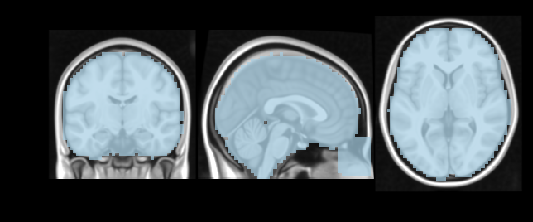

In [5]:
anat = '/home/neuro/workshop/notebooks/data/templates/MNI152_T1_1mm.nii.gz'
mask = get_mask('both')
plot_roi(mask, anat, cmap='Paired', dim=-.5, draw_cross=False, annotate=False)

`NiftiMasker` is an object that applies a mask to a dataset and returns the masked voxels as a vector at each time point.

In [6]:
from nilearn.input_data import NiftiMasker
masker = NiftiMasker(mask_img=mask, standardize=False, detrend=False,
                     memory="nilearn_cache", memory_level=2)
samples = masker.fit_transform(func)
print(samples)

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/input_data/base_masker.py:100: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_masker_extractor'
  memory_level=memory_level)(imgs)


[[0.7965089  0.9749323  0.9000536  ... 0.56139576 0.40530768 0.71668595]
 [0.9088199  0.7303408  0.63435954 ... 0.80835986 0.44824055 0.46237826]
 [0.6761813  0.8293086  0.9835918  ... 0.5358669  0.56062424 0.72024435]
 ...
 [0.81860083 0.8177914  1.0595632  ... 0.63843036 0.5614186  0.7092098 ]
 [0.8739697  0.6019776  1.0053024  ... 0.5492817  0.67479044 0.70944095]
 [0.8174745  0.9999173  0.9347665  ... 0.6070517  0.92529875 0.7956351 ]]


Its shape corresponds to the number of time-points times the number of voxels in the mask.

In [7]:
print(samples.shape)

(384, 37398)


To recover the original data shape (giving us a masked and z-scored BOLD series), we simply use the masker's inverse transform:

In [8]:
masked_epi = masker.inverse_transform(samples)

Let's now visualize the masked epi.

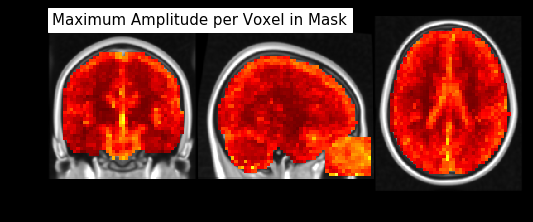

In [9]:
from nilearn.image import math_img
from nilearn.plotting import plot_stat_map

max_zscores = math_img("np.abs(img).max(axis=3)", img=masked_epi)
plot_stat_map(max_zscores, bg_img=anat, dim=-.5, cut_coords=[33, -20, 20],
              draw_cross=False, annotate=False, colorbar=False,
              title='Maximum Amplitude per Voxel in Mask')

# Simple MVPA Example

Multi-voxel pattern analysis (MVPA) is a general term for techniques that contrast conditions over multiple voxels. It's very common to use machine learning models to generate statistics of interest.

In this case, we'll use the response patterns of voxels in the mask to predict if the eyes were **closed** or **open** during a resting-state fMRI recording. But before we can do MVPA, we still need to specify two important parameters:

***First***, we need to know the label for each volume. From the last section of the [Machine Learning Preparation](machine_learning_preparation.ipynb) notebook, we know that we have a total of 384 volumes in our `dataset_ML.nii.gz` file and that it's always 4 volumes of the condition `eyes closed`, followed by 4 volumes of the condition `eyes open`, etc. Therefore our labels should be as follows:

In [10]:
labels = np.ravel([[['closed'] * 4, ['open'] * 4] for i in range(48)])
labels[:20]

array(['closed', 'closed', 'closed', 'closed', 'open', 'open', 'open',
       'open', 'closed', 'closed', 'closed', 'closed', 'open', 'open',
       'open', 'open', 'closed', 'closed', 'closed', 'closed'],
      dtype='<U6')

***Second***, we need the `chunks` parameter. This variable is important if we want to do for example cross-validation. In our case we would ideally create 48 chunks, one for each subject. But because a cross-validation of 48 chunks takes very long, let's just create 6 chunks, containing always 8 subjects, i.e. 64 volumes:

In [11]:
chunks = np.ravel([[i] * 64 for i in range(6)])
chunks[:100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

One way to do cross-validation is the so called **Leave-one-out cross-validation**. This approach trains on `(n - 1)` chunks, and classifies the remaining chunk, and repeats this for every chunk, also called **fold**. Therefore, a 6-fold cross-validation is one that divides the whole data into 6 different chunks.

Now that we have the labels and chunks ready, we're only missing the classifier. In `Scikit-Learn`, there are [many to choose from](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html), let's start with the most well known, a linear support vector classifier (SVC).

In [12]:
# Let's specify the classifier
from sklearn.svm import LinearSVC
clf = LinearSVC(penalty='l2', loss='squared_hinge', max_iter=25)

**Note:** The number of maximum iterations should ideally be much much bigger (around 1000), but was kept low here to reduce computation time.

Now, we're ready to train the classifier and do the cross-validation.

In [13]:
# Performe the cross validation (takes time to compute)
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score
cv_scores = cross_val_score(estimator=clf,
                            X=samples,
                            y=labels,
                            groups=chunks,
                            cv=LeaveOneGroupOut(),
                            n_jobs=-1,
                            verbose=1)

[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:    1.4s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    1.7s finished


After the cross validation was computed we can extract the overall accuracy, as well as the accuracy for each individual fold (i.e. leave-one-out prediction). Mean (across subject) cross-validation accuracy is a common statistic for classification-based MVPA.

In [14]:
print('Average accuracy = %.02f percent\n' % (cv_scores.mean() * 100))
print('Accuracy per fold:', cv_scores, sep='\n')

Average accuracy = 83.59 percent

Accuracy per fold:
[0.8125   0.703125 0.84375  0.875    0.875    0.90625 ]


**Wow, an average accuracy above 80%!!!** What if we use another classifier? Let's say a Gaussian Naive Bayes classifier?

In [15]:
# Let's specify a Gaussian Naive Bayes classifier
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

In [16]:
cv_scores = cross_val_score(estimator=clf,
                            X=samples,
                            y=labels,
                            groups=chunks,
                            cv=LeaveOneGroupOut(),
                            n_jobs=1,
                            verbose=1)

[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.7s finished


In [17]:
print('Average accuracy = %.02f percent\n' % (cv_scores.mean() * 100))
print('Accuracy per fold:', cv_scores, sep='\n')

Average accuracy = 79.43 percent

Accuracy per fold:
[0.75     0.796875 0.796875 0.796875 0.875    0.75    ]


That was much quicker but less accurate. As was expected. What about a Logistic Regression classifier?

In [18]:
# Let's specify a Logistic Regression classifier
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(penalty='l2', max_iter=25)

In [19]:
cv_scores = cross_val_score(estimator=clf,
                            X=samples,
                            y=labels,
                            groups=chunks,
                            cv=LeaveOneGroupOut(),
                            n_jobs=-1,
                            verbose=1)

[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:   11.5s remaining:   11.5s
[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:   12.7s finished


In [20]:
print('Average accuracy = %.02f percent\n' % (cv_scores.mean() * 100))
print('Accuracy per fold:', cv_scores, sep='\n')

Average accuracy = 85.16 percent

Accuracy per fold:
[0.828125 0.8125   0.8125   0.890625 0.875    0.890625]


The prediction accuracy is again above **80%**, much better! But anyhow, how do we know if an accuracy value is significant or not? Well, one way to find this out is to do some permutation testing.

## Permutation testing

One way to test the quality of the prediction accuracy is to run the cross-validation multiple times, but permutate the labels of the volumes randomly. Afterward we can compare the accuracy value of the correct labels to the ones with the random / false labels. Luckily `Scikit-learn` already has a function that does this for us. So let's do it.

**Note**: We chose again the `GaussianNB` classifier to reduce the computation time per cross-validation. Additionally, we chose the number of iterations under `n_permutations` for the permutation testing very low, to reduce computation time as well. This value should ideally be much higher, at least 100.

In [21]:
# Let's chose again the linear SVC
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

In [22]:
# Import the permuation function
from sklearn.model_selection import permutation_test_score

In [23]:
# Run the permuation cross-validation
null_cv_scores = permutation_test_score(estimator=clf,
                                        X=samples,
                                        y=labels,
                                        groups=chunks,
                                        cv=LeaveOneGroupOut(),
                                        n_permutations=25,
                                        n_jobs=-1,
                                        verbose=1)

[Parallel(n_jobs=-1)]: Done  20 out of  25 | elapsed:   11.6s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   12.1s finished


So, let's take a look at the results:

In [24]:
print('Prediction accuracy: %.02f' % (null_cv_scores[0] * 100),
      'p-value: %.04f' % (null_cv_scores[2]),
      sep='\n')

Prediction accuracy: 79.43
p-value: 0.0385


Great! This means... Using resting-state fMRI images, we can predict if a person had their eyes open or closed with an accuracy significantly above chance level!

# Which region is driving the classification?

With a simple MVPA approach, we unfortunately don't know which regions are driving the classification accuracy. We just know that all voxels in the mask allow the classification of the two classes, but why? We need a better technique that tells us where in the head we should look.

There are many different ways to figure out which region is important for classification, but let us introduce you two different approaches that you can use in `nilearn`: `SpaceNet` and  `Searchlight`

## SpaceNet: decoding with spatial structure for better maps

SpaceNet implements spatial penalties which improve brain decoding power as well as decoder maps. The results are brain maps which are both sparse (i.e regression coefficients are zero everywhere, except at predictive voxels) and structured (blobby). For more detail, check out `nilearn`'s section about [SpaceNet](http://nilearn.github.io/decoding/space_net.html).

To train a SpaceNet on our data, let's first split the data into a training set (chunk 0-4) and a test set (chunk 5). 

In [25]:
# Create two masks that specify the training and the test set 
mask_test = chunks == 5
mask_train = np.invert(mask_test)

In [26]:
# Apply this sample mask to X (fMRI data) and y (behavioral labels)
from nilearn.image import index_img
X_train = index_img(func, mask_train)
y_train = labels[mask_train]

X_test = index_img(func, mask_test)
y_test = labels[mask_test]

Now we can fit the SpaceNet to our data with a TV-l1 penalty. ***Note*** again, that we reduced the number of `max_iter` to have a quick computation. In a realistic case this value should be around 1000.

In [27]:
from nilearn.decoding import SpaceNetClassifier

# Fit model on train data and predict on test data
decoder = SpaceNetClassifier(penalty='tv-l1',
                             mask=get_mask('both'),
                             max_iter=10,
                             cv=5,
                             standardize=True,
                             memory="nilearn_cache",
                             memory_level=2,
                             verbose=1)

decoder.fit(X_train, y_train)

[NiftiMasker.fit] Loading data from None
[NiftiMasker.fit] Resampling mask
[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(40, 51, 41, 320),
affine=array([[  -4.,    0.,    0.,   78.],
       [   0.,    4.,    0., -114.],
       [   0.,    0.,    4.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/decoding/space_net.py:827: UserWarning: Brain mask is bigger than the volume of a standard human brain. This object is probably not tuned to be used on such data.
  self.screening_percentile, self.mask_img_, verbose=self.verbose)


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x7f3feaedad08>, loss='logistic'), array([[0.588454, ..., 0.029157],
       ...,
       [0.678369, ..., 2.213025]]), array([-1, ...,  1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([ 64, ..., 319]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]), 
{'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 0), debias=False, verbose=1, screening_percentile=15.268555470880802)


/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nilearn/decoding/objective_functions.py:209: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  gradient[slice_all] = np.diff(img, axis=d)


______________________________________________________path_scores - 2.5s, 0.0min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


________________________________________________________________________________
[Memory] Calling nilearn.decoding.space_net.path_scores...
path_scores(functools.partial(<function tvl1_solver at 0x7f3feaedad08>, loss='logistic'), array([[0.588454, ..., 0.029157],
       ...,
       [0.678369, ..., 2.213025]]), array([-1, ...,  1]), array([[[False, ..., False],
        ...,
        [False, ..., False]],

       ...,

       [[False, ..., False],
        ...,
        [False, ..., False]]]), 
None, [0.5], array([  0, ..., 319]), array([ 64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127]), 
{'max_iter': 10, 'tol': 0.0001}, n_alphas=10, eps=0.001, is_classif=True, key=(0, 1), debias=False, verbose=1,

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.3s finished


SpaceNetClassifier(alphas=None, cv=5, debias=False, eps=0.001,
          fit_intercept=True, high_pass=None, l1_ratios=0.5,
          loss='logistic', low_pass=None,
          mask=<nibabel.nifti1.Nifti1Image object at 0x7f3feb8a4c88>,
          max_iter=10, memory=Memory(cachedir='nilearn_cache/joblib'),
          memory_level=2, n_alphas=10, n_jobs=1, penalty='tv-l1',
          screening_percentile=20.0, standardize=True, t_r=None,
          target_affine=None, target_shape=None, tol=0.0001, verbose=1)

Now that the `SpaceNet` is fitted to the training data. Let's see how well it does in predicting the test data.

In [28]:
# Predict the labels of the test data
y_pred = decoder.predict(X_test)

[NiftiMasker.transform_single_imgs] Loading data from Nifti1Image(
shape=(40, 51, 41, 64),
affine=array([[  -4.,    0.,    0.,   78.],
       [   0.,    4.,    0., -114.],
       [   0.,    0.,    4.,  -72.],
       [   0.,    0.,    0.,    1.]])
)
[NiftiMasker.transform_single_imgs] Extracting region signals
[NiftiMasker.transform_single_imgs] Cleaning extracted signals


In [29]:
# Retrun average accuracy
accuracy = (y_pred == y_test).mean() * 100.
print("\nTV-l1  classification accuracy : %g%%" % accuracy)


TV-l1  classification accuracy : 85.9375%


Again above 80% prediction accuracy? But we wanted to know what's driving this prediction. So let's take a look at the fitting coefficients.

In [30]:
from nilearn.plotting import plot_stat_map, show
coef_img = decoder.coef_img_

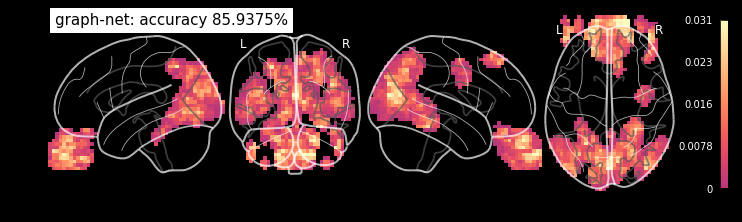

In [31]:
# Plotting the searchlight results on the glass brain
from nilearn.plotting import plot_glass_brain
plot_glass_brain(coef_img, black_bg=True, colorbar=True, display_mode='lyrz', symmetric_cbar=False,
                 cmap='magma', title='graph-net: accuracy %g%%' % accuracy)

Cool! As expected the visual cortex (in the back of the head) and the eyes are driving the classification!

## Searchlight

Now the next question is: How high would the prediction accuracy be if we only take one small region to do the classification?

To answer this question we can use something that is called a **Searchlight** approach. The searchlight approach was first proposed by [Kriegeskorte et al., 2006](https://pdfs.semanticscholar.org/985c/ceaca8606443f9129616a26bbbbf952f2d7f.pdf). It is a widely used approach for the study of the fine-grained patterns of information in fMRI analysis. Its principle is relatively simple: a small group of neighboring features is extracted from the data, and the prediction function is instantiated on these features only. The resulting prediction accuracy is thus associated with all the features within the group, or only with the feature on the center. This yields a map of local fine-grained information, that can be used for assessing hypothesis on the local spatial layout of the neural code under investigation.

You can do a searchlight analysis in `nilearn` as follows:

In [32]:
from nilearn.decoding import SearchLight

In [33]:
# Specify the mask in which the searchlight should be performed
mask = get_mask('both')

In [34]:
# Specify the classifier to use
# Let's use again a GaussainNB classifier to reduce computation time
clf = GaussianNB()

In [35]:
# Specify the radius of the searchlight sphere  that will scan the volume
# (the bigger the longer the computation)
sphere_radius = 8  # in mm

Now we're ready to create the searchlight object.

In [36]:
# Create searchlight object
sl = SearchLight(mask,
                 process_mask_img=mask,
                 radius=sphere_radius,
                 estimator=clf,
                 cv=LeaveOneGroupOut(),
                 n_jobs=-1,
                 verbose=1)

In [37]:
# Run the searchlight algorithm
sl.fit(nb.load(func), labels, groups=chunks)

Job #1, processed 0/2338 voxels (0.00%, 177 seconds remaining)
Job #2, processed 0/2338 voxels (0.00%, 165 seconds remaining)
Job #1, processed 10/2338 voxels (0.43%, 32 seconds remaining)
Job #1, processed 20/2338 voxels (0.86%, 26 seconds remaining)
Job #3, processed 0/2338 voxels (0.00%, 167 seconds remaining)
Job #2, processed 10/2338 voxels (0.43%, 35 seconds remaining)
Job #1, processed 30/2338 voxels (1.28%, 24 seconds remaining)
Job #4, processed 0/2338 voxels (0.00%, 193 seconds remaining)
Job #2, processed 20/2338 voxels (0.86%, 27 seconds remaining)
Job #3, processed 10/2338 voxels (0.43%, 42 seconds remaining)
Job #1, processed 40/2338 voxels (1.71%, 23 seconds remaining)
Job #2, processed 30/2338 voxels (1.28%, 24 seconds remaining)
Job #5, processed 0/2338 voxels (0.00%, 210 seconds remaining)
Job #4, processed 10/2338 voxels (0.43%, 33 seconds remaining)
Job #3, processed 20/2338 voxels (0.86%, 31 seconds remaining)
Job #1, processed 50/2338 voxels (2.14%, 22 seconds rem

Job #12, processed 40/2337 voxels (1.71%, 25 seconds remaining)
Job #2, processed 150/2338 voxels (6.42%, 20 seconds remaining)
Job #3, processed 130/2338 voxels (5.56%, 22 seconds remaining)
Job #8, processed 70/2337 voxels (3.00%, 26 seconds remaining)
Job #4, processed 130/2338 voxels (5.56%, 20 seconds remaining)
Job #1, processed 160/2338 voxels (6.84%, 20 seconds remaining)
Job #7, processed 90/2337 voxels (3.85%, 24 seconds remaining)
Job #15, processed 20/2337 voxels (0.86%, 26 seconds remaining)
Job #10, processed 70/2337 voxels (3.00%, 22 seconds remaining)
Job #9, processed 80/2337 voxels (3.42%, 22 seconds remaining)
Job #16, processed 10/2337 voxels (0.43%, 38 seconds remaining)
Job #6, processed 110/2338 voxels (4.70%, 21 seconds remaining)
Job #14, processed 30/2337 voxels (1.28%, 28 seconds remaining)
Job #11, processed 50/2337 voxels (2.14%, 28 seconds remaining)
Job #2, processed 160/2338 voxels (6.84%, 20 seconds remaining)
Job #12, processed 50/2337 voxels (2.14%, 2

Job #6, processed 180/2338 voxels (7.70%, 23 seconds remaining)
Job #8, processed 150/2337 voxels (6.42%, 25 seconds remaining)
Job #9, processed 150/2337 voxels (6.42%, 24 seconds remaining)
Job #2, processed 240/2338 voxels (10.27%, 20 seconds remaining)
Job #7, processed 170/2337 voxels (7.27%, 23 seconds remaining)
Job #4, processed 210/2338 voxels (8.98%, 22 seconds remaining)
Job #1, processed 240/2338 voxels (10.27%, 21 seconds remaining)
Job #16, processed 90/2337 voxels (3.85%, 26 seconds remaining)
Job #3, processed 210/2338 voxels (8.98%, 23 seconds remaining)
Job #12, processed 130/2337 voxels (5.56%, 24 seconds remaining)
Job #5, processed 200/2338 voxels (8.55%, 22 seconds remaining)
Job #10, processed 150/2337 voxels (6.42%, 23 seconds remaining)
Job #13, processed 120/2337 voxels (5.13%, 25 seconds remaining)
Job #14, processed 110/2337 voxels (4.71%, 26 seconds remaining)
Job #11, processed 130/2337 voxels (5.56%, 26 seconds remaining)
Job #6, processed 190/2338 voxels

Job #8, processed 230/2337 voxels (9.84%, 24 seconds remaining)
Job #11, processed 200/2337 voxels (8.56%, 25 seconds remaining)
Job #5, processed 270/2338 voxels (11.55%, 22 seconds remaining)
Job #3, processed 290/2338 voxels (12.40%, 22 seconds remaining)
Job #16, processed 160/2337 voxels (6.85%, 26 seconds remaining)
Job #15, processed 170/2337 voxels (7.27%, 26 seconds remaining)
Job #7, processed 250/2337 voxels (10.70%, 23 seconds remaining)
Job #2, processed 320/2338 voxels (13.69%, 20 seconds remaining)
Job #13, processed 200/2337 voxels (8.56%, 24 seconds remaining)
Job #6, processed 270/2338 voxels (11.55%, 22 seconds remaining)
Job #9, processed 240/2337 voxels (10.27%, 23 seconds remaining)
Job #12, processed 210/2337 voxels (8.99%, 24 seconds remaining)
Job #1, processed 330/2338 voxels (14.11%, 20 seconds remaining)
Job #4, processed 290/2338 voxels (12.40%, 22 seconds remaining)
Job #10, processed 230/2337 voxels (9.84%, 23 seconds remaining)
Job #14, processed 190/233

Job #9, processed 310/2337 voxels (13.26%, 22 seconds remaining)
Job #6, processed 340/2338 voxels (14.54%, 22 seconds remaining)
Job #16, processed 230/2337 voxels (9.84%, 26 seconds remaining)
Job #8, processed 310/2337 voxels (13.26%, 23 seconds remaining)
Job #15, processed 250/2337 voxels (10.70%, 24 seconds remaining)
Job #1, processed 410/2338 voxels (17.54%, 20 seconds remaining)
Job #12, processed 290/2337 voxels (12.41%, 23 seconds remaining)
Job #7, processed 330/2337 voxels (14.12%, 22 seconds remaining)
Job #4, processed 370/2338 voxels (15.83%, 21 seconds remaining)
Job #3, processed 370/2338 voxels (15.83%, 22 seconds remaining)
Job #11, processed 280/2337 voxels (11.98%, 24 seconds remaining)
Job #14, processed 270/2337 voxels (11.55%, 23 seconds remaining)
Job #2, processed 400/2338 voxels (17.11%, 20 seconds remaining)
Job #6, processed 350/2338 voxels (14.97%, 22 seconds remaining)
Job #9, processed 320/2337 voxels (13.69%, 22 seconds remaining)
Job #10, processed 31

Job #14, processed 350/2337 voxels (14.98%, 22 seconds remaining)
Job #16, processed 300/2337 voxels (12.84%, 25 seconds remaining)
Job #6, processed 420/2338 voxels (17.96%, 21 seconds remaining)
Job #9, processed 390/2337 voxels (16.69%, 22 seconds remaining)
Job #15, processed 320/2337 voxels (13.69%, 24 seconds remaining)
Job #13, processed 360/2337 voxels (15.40%, 22 seconds remaining)
Job #8, processed 390/2337 voxels (16.69%, 22 seconds remaining)
Job #2, processed 470/2338 voxels (20.10%, 20 seconds remaining)
Job #3, processed 450/2338 voxels (19.25%, 21 seconds remaining)
Job #7, processed 420/2337 voxels (17.97%, 21 seconds remaining)
Job #4, processed 450/2338 voxels (19.25%, 20 seconds remaining)
Job #1, processed 500/2338 voxels (21.39%, 19 seconds remaining)
Job #12, processed 360/2337 voxels (15.40%, 23 seconds remaining)
Job #14, processed 360/2337 voxels (15.40%, 22 seconds remaining)
Job #10, processed 390/2337 voxels (16.69%, 22 seconds remaining)
Job #11, processed

Job #12, processed 430/2337 voxels (18.40%, 22 seconds remaining)
Job #5, processed 510/2338 voxels (21.81%, 20 seconds remaining)
Job #8, processed 470/2337 voxels (20.11%, 21 seconds remaining)
Job #7, processed 490/2337 voxels (20.97%, 21 seconds remaining)
Job #11, processed 430/2337 voxels (18.40%, 23 seconds remaining)
Job #2, processed 550/2338 voxels (23.52%, 19 seconds remaining)
Job #3, processed 530/2338 voxels (22.67%, 20 seconds remaining)
Job #1, processed 570/2338 voxels (24.38%, 19 seconds remaining)
Job #15, processed 400/2337 voxels (17.12%, 23 seconds remaining)
Job #16, processed 390/2337 voxels (16.69%, 24 seconds remaining)
Job #4, processed 530/2338 voxels (22.67%, 20 seconds remaining)
Job #13, processed 440/2337 voxels (18.83%, 21 seconds remaining)
Job #14, processed 440/2337 voxels (18.83%, 21 seconds remaining)
Job #12, processed 440/2337 voxels (18.83%, 22 seconds remaining)
Job #6, processed 500/2338 voxels (21.39%, 21 seconds remaining)
Job #10, processed

Job #7, processed 570/2337 voxels (24.39%, 20 seconds remaining)
Job #1, processed 650/2338 voxels (27.80%, 18 seconds remaining)
Job #4, processed 610/2338 voxels (26.09%, 19 seconds remaining)
Job #11, processed 500/2337 voxels (21.39%, 22 seconds remaining)
Job #15, processed 480/2337 voxels (20.54%, 22 seconds remaining)
Job #12, processed 510/2337 voxels (21.82%, 21 seconds remaining)
Job #2, processed 630/2338 voxels (26.95%, 19 seconds remaining)
Job #8, processed 560/2337 voxels (23.96%, 20 seconds remaining)
Job #6, processed 570/2338 voxels (24.38%, 20 seconds remaining)
Job #9, processed 550/2337 voxels (23.53%, 20 seconds remaining)
Job #16, processed 470/2337 voxels (20.11%, 23 seconds remaining)
Job #3, processed 610/2338 voxels (26.09%, 19 seconds remaining)
Job #5, processed 600/2338 voxels (25.66%, 19 seconds remaining)
Job #13, processed 510/2337 voxels (21.82%, 21 seconds remaining)
Job #10, processed 550/2337 voxels (23.53%, 20 seconds remaining)
Job #4, processed 6

Job #9, processed 630/2337 voxels (26.96%, 19 seconds remaining)
Job #6, processed 650/2338 voxels (27.80%, 19 seconds remaining)
Job #15, processed 560/2337 voxels (23.96%, 21 seconds remaining)
Job #16, processed 550/2337 voxels (23.53%, 21 seconds remaining)
Job #13, processed 580/2337 voxels (24.82%, 21 seconds remaining)
Job #14, processed 590/2337 voxels (25.25%, 20 seconds remaining)
Job #3, processed 680/2338 voxels (29.08%, 19 seconds remaining)
Job #2, processed 710/2338 voxels (30.37%, 18 seconds remaining)
Job #11, processed 580/2337 voxels (24.82%, 21 seconds remaining)
Job #12, processed 590/2337 voxels (25.25%, 21 seconds remaining)
Job #6, processed 660/2338 voxels (28.23%, 19 seconds remaining)
Job #7, processed 650/2337 voxels (27.81%, 19 seconds remaining)
Job #10, processed 630/2337 voxels (26.96%, 19 seconds remaining)
Job #8, processed 630/2337 voxels (26.96%, 20 seconds remaining)
Job #4, processed 700/2338 voxels (29.94%, 18 seconds remaining)
Job #1, processed 

Job #2, processed 780/2338 voxels (33.36%, 18 seconds remaining)
Job #6, processed 740/2338 voxels (31.65%, 18 seconds remaining)
Job #16, processed 630/2337 voxels (26.96%, 21 seconds remaining)
Job #3, processed 760/2338 voxels (32.51%, 18 seconds remaining)
Job #4, processed 770/2338 voxels (32.93%, 18 seconds remaining)
Job #9, processed 710/2337 voxels (30.38%, 19 seconds remaining)
Job #7, processed 720/2337 voxels (30.81%, 19 seconds remaining)
Job #14, processed 670/2337 voxels (28.67%, 20 seconds remaining)
Job #11, processed 660/2337 voxels (28.24%, 21 seconds remaining)
Job #10, processed 710/2337 voxels (30.38%, 19 seconds remaining)
Job #1, processed 820/2338 voxels (35.07%, 17 seconds remaining)
Job #5, processed 740/2338 voxels (31.65%, 19 seconds remaining)
Job #8, processed 700/2337 voxels (29.95%, 20 seconds remaining)
Job #12, processed 670/2337 voxels (28.67%, 20 seconds remaining)
Job #2, processed 790/2338 voxels (33.79%, 18 seconds remaining)
Job #3, processed 77

Job #12, processed 740/2337 voxels (31.66%, 19 seconds remaining)
Job #11, processed 740/2337 voxels (31.66%, 19 seconds remaining)
Job #14, processed 740/2337 voxels (31.66%, 19 seconds remaining)
Job #3, processed 840/2338 voxels (35.93%, 17 seconds remaining)
Job #5, processed 820/2338 voxels (35.07%, 18 seconds remaining)
Job #4, processed 850/2338 voxels (36.36%, 17 seconds remaining)
Job #7, processed 800/2337 voxels (34.23%, 18 seconds remaining)
Job #6, processed 820/2338 voxels (35.07%, 18 seconds remaining)
Job #1, processed 900/2338 voxels (38.49%, 16 seconds remaining)
Job #15, processed 730/2337 voxels (31.24%, 19 seconds remaining)
Job #2, processed 870/2338 voxels (37.21%, 17 seconds remaining)
Job #16, processed 710/2337 voxels (30.38%, 20 seconds remaining)
Job #10, processed 790/2337 voxels (33.80%, 18 seconds remaining)
Job #13, processed 750/2337 voxels (32.09%, 19 seconds remaining)
Job #8, processed 780/2337 voxels (33.38%, 19 seconds remaining)
Job #12, processed

Job #16, processed 780/2337 voxels (33.38%, 19 seconds remaining)
Job #1, processed 970/2338 voxels (41.49%, 15 seconds remaining)
Job #5, processed 900/2338 voxels (38.49%, 17 seconds remaining)
Job #8, processed 850/2337 voxels (36.37%, 18 seconds remaining)
Job #3, processed 920/2338 voxels (39.35%, 16 seconds remaining)
Job #7, processed 880/2337 voxels (37.66%, 17 seconds remaining)
Job #10, processed 870/2337 voxels (37.23%, 17 seconds remaining)
Job #11, processed 820/2337 voxels (35.09%, 19 seconds remaining)
Job #15, processed 810/2337 voxels (34.66%, 18 seconds remaining)
Job #14, processed 820/2337 voxels (35.09%, 18 seconds remaining)
Job #12, processed 830/2337 voxels (35.52%, 18 seconds remaining)
Job #6, processed 900/2338 voxels (38.49%, 17 seconds remaining)
Job #9, processed 870/2337 voxels (37.23%, 17 seconds remaining)
Job #16, processed 790/2337 voxels (33.80%, 19 seconds remaining)
Job #13, processed 820/2337 voxels (35.09%, 18 seconds remaining)
Job #2, processed

Job #11, processed 890/2337 voxels (38.08%, 18 seconds remaining)
Job #10, processed 950/2337 voxels (40.65%, 16 seconds remaining)
Job #9, processed 940/2337 voxels (40.22%, 16 seconds remaining)
Job #3, processed 1000/2338 voxels (42.77%, 15 seconds remaining)
Job #12, processed 910/2337 voxels (38.94%, 17 seconds remaining)
Job #14, processed 900/2337 voxels (38.51%, 17 seconds remaining)
Job #15, processed 890/2337 voxels (38.08%, 17 seconds remaining)
Job #16, processed 870/2337 voxels (37.23%, 18 seconds remaining)
Job #4, processed 1010/2338 voxels (43.20%, 15 seconds remaining)
Job #1, processed 1050/2338 voxels (44.91%, 14 seconds remaining)
Job #5, processed 980/2338 voxels (41.92%, 16 seconds remaining)
Job #7, processed 960/2337 voxels (41.08%, 16 seconds remaining)
Job #13, processed 900/2337 voxels (38.51%, 17 seconds remaining)
Job #2, processed 1030/2338 voxels (44.05%, 15 seconds remaining)
Job #6, processed 980/2338 voxels (41.92%, 16 seconds remaining)
Job #11, proce

Job #6, processed 1050/2338 voxels (44.91%, 15 seconds remaining)
Job #5, processed 1060/2338 voxels (45.34%, 15 seconds remaining)
Job #3, processed 1080/2338 voxels (46.19%, 14 seconds remaining)
Job #12, processed 980/2337 voxels (41.93%, 16 seconds remaining)
Job #15, processed 960/2337 voxels (41.08%, 16 seconds remaining)
Job #14, processed 980/2337 voxels (41.93%, 16 seconds remaining)
Job #7, processed 1030/2337 voxels (44.07%, 15 seconds remaining)
Job #11, processed 970/2337 voxels (41.51%, 17 seconds remaining)
Job #8, processed 1010/2337 voxels (43.22%, 16 seconds remaining)
Job #10, processed 1040/2337 voxels (44.50%, 15 seconds remaining)
Job #16, processed 960/2337 voxels (41.08%, 16 seconds remaining)
Job #9, processed 1020/2337 voxels (43.65%, 15 seconds remaining)
Job #13, processed 980/2337 voxels (41.93%, 16 seconds remaining)
Job #2, processed 1100/2338 voxels (47.05%, 14 seconds remaining)
Job #1, processed 1130/2338 voxels (48.33%, 14 seconds remaining)
Job #6, p

Job #11, processed 1040/2337 voxels (44.50%, 16 seconds remaining)
Job #9, processed 1090/2337 voxels (46.64%, 15 seconds remaining)
Job #5, processed 1140/2338 voxels (48.76%, 14 seconds remaining)
Job #4, processed 1150/2338 voxels (49.19%, 14 seconds remaining)
Job #8, processed 1090/2337 voxels (46.64%, 15 seconds remaining)
Job #16, processed 1040/2337 voxels (44.50%, 15 seconds remaining)
Job #14, processed 1050/2337 voxels (44.93%, 15 seconds remaining)
Job #3, processed 1160/2338 voxels (49.62%, 14 seconds remaining)
Job #7, processed 1100/2337 voxels (47.07%, 15 seconds remaining)
Job #6, processed 1130/2338 voxels (48.33%, 14 seconds remaining)
Job #2, processed 1180/2338 voxels (50.47%, 13 seconds remaining)
Job #10, processed 1120/2337 voxels (47.92%, 14 seconds remaining)
Job #15, processed 1050/2337 voxels (44.93%, 15 seconds remaining)
Job #1, processed 1210/2338 voxels (51.75%, 13 seconds remaining)
Job #3, processed 1170/2338 voxels (50.04%, 13 seconds remaining)
Job #

Job #6, processed 1200/2338 voxels (51.33%, 13 seconds remaining)
Job #13, processed 1130/2337 voxels (48.35%, 14 seconds remaining)
Job #11, processed 1110/2337 voxels (47.50%, 15 seconds remaining)
Job #1, processed 1280/2338 voxels (54.75%, 12 seconds remaining)
Job #8, processed 1170/2337 voxels (50.06%, 14 seconds remaining)
Job #5, processed 1220/2338 voxels (52.18%, 13 seconds remaining)
Job #2, processed 1260/2338 voxels (53.89%, 12 seconds remaining)
Job #12, processed 1140/2337 voxels (48.78%, 14 seconds remaining)
Job #4, processed 1230/2338 voxels (52.61%, 13 seconds remaining)
Job #16, processed 1120/2337 voxels (47.92%, 14 seconds remaining)
Job #7, processed 1180/2337 voxels (50.49%, 14 seconds remaining)
Job #10, processed 1200/2337 voxels (51.35%, 13 seconds remaining)
Job #14, processed 1120/2337 voxels (47.92%, 15 seconds remaining)
Job #9, processed 1180/2337 voxels (50.49%, 13 seconds remaining)
Job #6, processed 1210/2338 voxels (51.75%, 13 seconds remaining)
Job 

Job #4, processed 1300/2338 voxels (55.60%, 12 seconds remaining)
Job #9, processed 1250/2337 voxels (53.49%, 13 seconds remaining)
Job #11, processed 1190/2337 voxels (50.92%, 14 seconds remaining)
Job #8, processed 1240/2337 voxels (53.06%, 13 seconds remaining)
Job #5, processed 1300/2338 voxels (55.60%, 12 seconds remaining)
Job #1, processed 1360/2338 voxels (58.17%, 11 seconds remaining)
Job #3, processed 1320/2338 voxels (56.46%, 12 seconds remaining)
Job #15, processed 1200/2337 voxels (51.35%, 13 seconds remaining)
Job #14, processed 1190/2337 voxels (50.92%, 14 seconds remaining)
Job #16, processed 1200/2337 voxels (51.35%, 13 seconds remaining)
Job #12, processed 1220/2337 voxels (52.20%, 13 seconds remaining)
Job #13, processed 1210/2337 voxels (51.78%, 13 seconds remaining)
Job #10, processed 1280/2337 voxels (54.77%, 12 seconds remaining)
Job #2, processed 1350/2338 voxels (57.74%, 11 seconds remaining)
Job #6, processed 1290/2338 voxels (55.18%, 12 seconds remaining)
Job

Job #4, processed 1380/2338 voxels (59.02%, 11 seconds remaining)
Job #15, processed 1270/2337 voxels (54.34%, 12 seconds remaining)
Job #16, processed 1270/2337 voxels (54.34%, 12 seconds remaining)
Job #13, processed 1280/2337 voxels (54.77%, 12 seconds remaining)
Job #6, processed 1360/2338 voxels (58.17%, 11 seconds remaining)
Job #5, processed 1380/2338 voxels (59.02%, 11 seconds remaining)
Job #1, processed 1440/2338 voxels (61.59%, 10 seconds remaining)
Job #9, processed 1330/2337 voxels (56.91%, 12 seconds remaining)
Job #8, processed 1320/2337 voxels (56.48%, 12 seconds remaining)
Job #10, processed 1360/2337 voxels (58.19%, 11 seconds remaining)
Job #12, processed 1300/2337 voxels (55.63%, 12 seconds remaining)
Job #14, processed 1270/2337 voxels (54.34%, 13 seconds remaining)
Job #2, processed 1430/2338 voxels (61.16%, 10 seconds remaining)
Job #11, processed 1270/2337 voxels (54.34%, 13 seconds remaining)
Job #3, processed 1400/2338 voxels (59.88%, 11 seconds remaining)
Job

Job #11, processed 1340/2337 voxels (57.34%, 12 seconds remaining)
Job #5, processed 1460/2338 voxels (62.45%, 10 seconds remaining)
Job #8, processed 1390/2337 voxels (59.48%, 11 seconds remaining)
Job #13, processed 1360/2337 voxels (58.19%, 11 seconds remaining)
Job #10, processed 1440/2337 voxels (61.62%, 10 seconds remaining)
Job #9, processed 1400/2337 voxels (59.91%, 11 seconds remaining)
Job #1, processed 1520/2338 voxels (65.01%, 9 seconds remaining)
Job #14, processed 1350/2337 voxels (57.77%, 12 seconds remaining)
Job #6, processed 1440/2338 voxels (61.59%, 10 seconds remaining)
Job #15, processed 1350/2337 voxels (57.77%, 12 seconds remaining)
Job #7, processed 1420/2337 voxels (60.76%, 11 seconds remaining)
Job #2, processed 1500/2338 voxels (64.16%, 9 seconds remaining)
Job #12, processed 1380/2337 voxels (59.05%, 11 seconds remaining)
Job #4, processed 1460/2338 voxels (62.45%, 10 seconds remaining)
Job #11, processed 1350/2337 voxels (57.77%, 12 seconds remaining)
Job #

Job #4, processed 1530/2338 voxels (65.44%, 9 seconds remaining)
Job #14, processed 1420/2337 voxels (60.76%, 11 seconds remaining)
Job #8, processed 1470/2337 voxels (62.90%, 10 seconds remaining)
Job #11, processed 1420/2337 voxels (60.76%, 11 seconds remaining)
Job #1, processed 1590/2338 voxels (68.01%, 8 seconds remaining)
Job #16, processed 1420/2337 voxels (60.76%, 11 seconds remaining)
Job #6, processed 1520/2338 voxels (65.01%, 9 seconds remaining)
Job #15, processed 1430/2337 voxels (61.19%, 10 seconds remaining)
Job #13, processed 1440/2337 voxels (61.62%, 10 seconds remaining)
Job #7, processed 1500/2337 voxels (64.18%, 10 seconds remaining)
Job #10, processed 1520/2337 voxels (65.04%, 9 seconds remaining)
Job #5, processed 1540/2338 voxels (65.87%, 9 seconds remaining)
Job #9, processed 1480/2337 voxels (63.33%, 10 seconds remaining)
Job #12, processed 1460/2337 voxels (62.47%, 10 seconds remaining)
Job #3, processed 1560/2338 voxels (66.72%, 9 seconds remaining)
Job #2, p

Job #6, processed 1590/2338 voxels (68.01%, 8 seconds remaining)
Job #1, processed 1670/2338 voxels (71.43%, 7 seconds remaining)
Job #8, processed 1550/2337 voxels (66.32%, 9 seconds remaining)
Job #12, processed 1530/2337 voxels (65.47%, 9 seconds remaining)
Job #14, processed 1500/2337 voxels (64.18%, 10 seconds remaining)
Job #7, processed 1580/2337 voxels (67.61%, 9 seconds remaining)
Job #4, processed 1610/2338 voxels (68.86%, 8 seconds remaining)
Job #15, processed 1510/2337 voxels (64.61%, 9 seconds remaining)
Job #2, processed 1650/2338 voxels (70.57%, 8 seconds remaining)
Job #16, processed 1500/2337 voxels (64.18%, 10 seconds remaining)
Job #9, processed 1560/2337 voxels (66.75%, 9 seconds remaining)
Job #5, processed 1620/2338 voxels (69.29%, 8 seconds remaining)
Job #3, processed 1640/2338 voxels (70.15%, 8 seconds remaining)
Job #1, processed 1680/2338 voxels (71.86%, 7 seconds remaining)
Job #11, processed 1500/2337 voxels (64.18%, 10 seconds remaining)
Job #13, processe

Job #3, processed 1710/2338 voxels (73.14%, 7 seconds remaining)
Job #12, processed 1610/2337 voxels (68.89%, 8 seconds remaining)
Job #11, processed 1570/2337 voxels (67.18%, 9 seconds remaining)
Job #9, processed 1630/2337 voxels (69.75%, 8 seconds remaining)
Job #10, processed 1670/2337 voxels (71.46%, 7 seconds remaining)
Job #14, processed 1580/2337 voxels (67.61%, 9 seconds remaining)
Job #8, processed 1620/2337 voxels (69.32%, 8 seconds remaining)
Job #4, processed 1690/2338 voxels (72.28%, 7 seconds remaining)
Job #15, processed 1600/2337 voxels (68.46%, 8 seconds remaining)
Job #2, processed 1740/2338 voxels (74.42%, 7 seconds remaining)
Job #1, processed 1760/2338 voxels (75.28%, 6 seconds remaining)
Job #16, processed 1580/2337 voxels (67.61%, 9 seconds remaining)
Job #5, processed 1700/2338 voxels (72.71%, 7 seconds remaining)
Job #13, processed 1600/2337 voxels (68.46%, 8 seconds remaining)
Job #6, processed 1670/2338 voxels (71.43%, 8 seconds remaining)
Job #3, processed 

Job #9, processed 1710/2337 voxels (73.17%, 7 seconds remaining)
Job #14, processed 1660/2337 voxels (71.03%, 8 seconds remaining)
Job #7, processed 1730/2337 voxels (74.03%, 7 seconds remaining)
Job #1, processed 1830/2338 voxels (78.27%, 5 seconds remaining)
Job #8, processed 1700/2337 voxels (72.74%, 7 seconds remaining)
Job #15, processed 1670/2337 voxels (71.46%, 8 seconds remaining)
Job #12, processed 1690/2337 voxels (72.31%, 7 seconds remaining)
Job #4, processed 1770/2338 voxels (75.71%, 6 seconds remaining)
Job #5, processed 1780/2338 voxels (76.13%, 6 seconds remaining)
Job #16, processed 1650/2337 voxels (70.60%, 8 seconds remaining)
Job #11, processed 1650/2337 voxels (70.60%, 8 seconds remaining)
Job #6, processed 1750/2338 voxels (74.85%, 7 seconds remaining)
Job #2, processed 1820/2338 voxels (77.84%, 6 seconds remaining)
Job #3, processed 1800/2338 voxels (76.99%, 6 seconds remaining)
Job #10, processed 1760/2337 voxels (75.31%, 6 seconds remaining)
Job #13, processed 

Job #9, processed 1790/2337 voxels (76.59%, 6 seconds remaining)
Job #8, processed 1780/2337 voxels (76.17%, 6 seconds remaining)
Job #10, processed 1830/2337 voxels (78.31%, 5 seconds remaining)
Job #14, processed 1740/2337 voxels (74.45%, 7 seconds remaining)
Job #16, processed 1720/2337 voxels (73.60%, 7 seconds remaining)
Job #7, processed 1810/2337 voxels (77.45%, 6 seconds remaining)
Job #4, processed 1850/2338 voxels (79.13%, 5 seconds remaining)
Job #15, processed 1750/2337 voxels (74.88%, 7 seconds remaining)
Job #12, processed 1770/2337 voxels (75.74%, 6 seconds remaining)
Job #13, processed 1760/2337 voxels (75.31%, 6 seconds remaining)
Job #3, processed 1880/2338 voxels (80.41%, 5 seconds remaining)
Job #1, processed 1910/2338 voxels (81.69%, 5 seconds remaining)
Job #5, processed 1860/2338 voxels (79.56%, 5 seconds remaining)
Job #11, processed 1730/2337 voxels (74.03%, 7 seconds remaining)
Job #6, processed 1830/2338 voxels (78.27%, 6 seconds remaining)
Job #8, processed 

Job #7, processed 1880/2337 voxels (80.45%, 5 seconds remaining)
Job #6, processed 1900/2338 voxels (81.27%, 5 seconds remaining)
Job #12, processed 1840/2337 voxels (78.73%, 5 seconds remaining)
Job #16, processed 1800/2337 voxels (77.02%, 6 seconds remaining)
Job #4, processed 1930/2338 voxels (82.55%, 4 seconds remaining)
Job #1, processed 1990/2338 voxels (85.12%, 4 seconds remaining)
Job #3, processed 1960/2338 voxels (83.83%, 4 seconds remaining)
Job #15, processed 1830/2337 voxels (78.31%, 6 seconds remaining)
Job #9, processed 1870/2337 voxels (80.02%, 5 seconds remaining)
Job #14, processed 1820/2337 voxels (77.88%, 6 seconds remaining)
Job #8, processed 1870/2337 voxels (80.02%, 5 seconds remaining)
Job #10, processed 1910/2337 voxels (81.73%, 5 seconds remaining)
Job #13, processed 1840/2337 voxels (78.73%, 5 seconds remaining)
Job #11, processed 1810/2337 voxels (77.45%, 6 seconds remaining)
Job #6, processed 1910/2338 voxels (81.69%, 5 seconds remaining)
Job #2, processed 

Job #13, processed 1910/2337 voxels (81.73%, 5 seconds remaining)
Job #12, processed 1920/2337 voxels (82.16%, 5 seconds remaining)
Job #10, processed 1980/2337 voxels (84.72%, 4 seconds remaining)
Job #16, processed 1880/2337 voxels (80.45%, 5 seconds remaining)
Job #11, processed 1880/2337 voxels (80.45%, 5 seconds remaining)
Job #2, processed 2050/2338 voxels (87.68%, 3 seconds remaining)
Job #4, processed 2010/2338 voxels (85.97%, 3 seconds remaining)
Job #14, processed 1900/2337 voxels (81.30%, 5 seconds remaining)
Job #15, processed 1910/2337 voxels (81.73%, 5 seconds remaining)
Job #9, processed 1950/2337 voxels (83.44%, 4 seconds remaining)
Job #6, processed 1990/2338 voxels (85.12%, 4 seconds remaining)
Job #1, processed 2070/2338 voxels (88.54%, 3 seconds remaining)
Job #5, processed 2020/2338 voxels (86.40%, 3 seconds remaining)
Job #7, processed 1970/2337 voxels (84.30%, 4 seconds remaining)
Job #8, processed 1950/2337 voxels (83.44%, 4 seconds remaining)
Job #3, processed 

Job #6, processed 2060/2338 voxels (88.11%, 3 seconds remaining)
Job #7, processed 2040/2337 voxels (87.29%, 3 seconds remaining)
Job #14, processed 1970/2337 voxels (84.30%, 4 seconds remaining)
Job #15, processed 1990/2337 voxels (85.15%, 4 seconds remaining)
Job #16, processed 1960/2337 voxels (83.87%, 4 seconds remaining)
Job #5, processed 2090/2338 voxels (89.39%, 2 seconds remaining)
Job #13, processed 2000/2337 voxels (85.58%, 4 seconds remaining)
Job #4, processed 2090/2338 voxels (89.39%, 2 seconds remaining)
Job #8, processed 2030/2337 voxels (86.86%, 3 seconds remaining)
Job #12, processed 2000/2337 voxels (85.58%, 4 seconds remaining)
Job #9, processed 2030/2337 voxels (86.86%, 3 seconds remaining)
Job #11, processed 1960/2337 voxels (83.87%, 4 seconds remaining)
Job #3, processed 2110/2338 voxels (90.25%, 2 seconds remaining)
Job #10, processed 2070/2337 voxels (88.58%, 3 seconds remaining)
Job #2, processed 2140/2338 voxels (91.53%, 2 seconds remaining)
Job #6, processed 

Job #14, processed 2040/2337 voxels (87.29%, 3 seconds remaining)
Job #11, processed 2030/2337 voxels (86.86%, 3 seconds remaining)
Job #2, processed 2210/2338 voxels (94.53%, 1 seconds remaining)
Job #12, processed 2080/2337 voxels (89.00%, 3 seconds remaining)
Job #4, processed 2170/2338 voxels (92.81%, 1 seconds remaining)
Job #3, processed 2190/2338 voxels (93.67%, 1 seconds remaining)
Job #15, processed 2070/2337 voxels (88.58%, 3 seconds remaining)
Job #8, processed 2110/2337 voxels (90.29%, 2 seconds remaining)
Job #10, processed 2140/2337 voxels (91.57%, 2 seconds remaining)
Job #9, processed 2110/2337 voxels (90.29%, 2 seconds remaining)
Job #6, processed 2150/2338 voxels (91.96%, 2 seconds remaining)
Job #13, processed 2080/2337 voxels (89.00%, 3 seconds remaining)
Job #7, processed 2130/2337 voxels (91.14%, 2 seconds remaining)
Job #5, processed 2170/2338 voxels (92.81%, 1 seconds remaining)
Job #14, processed 2050/2337 voxels (87.72%, 3 seconds remaining)
Job #1, processed 

Job #15, processed 2140/2337 voxels (91.57%, 2 seconds remaining)
Job #5, processed 2240/2338 voxels (95.81%, 1 seconds remaining)
Job #16, processed 2110/2337 voxels (90.29%, 2 seconds remaining)
Job #7, processed 2200/2337 voxels (94.14%, 1 seconds remaining)
Job #4, processed 2250/2338 voxels (96.24%, 1 seconds remaining)
Job #3, processed 2270/2338 voxels (97.09%, 0 seconds remaining)
Job #2, processed 2290/2338 voxels (97.95%, 0 seconds remaining)
Job #11, processed 2110/2337 voxels (90.29%, 2 seconds remaining)
Job #8, processed 2190/2337 voxels (93.71%, 1 seconds remaining)
Job #13, processed 2160/2337 voxels (92.43%, 2 seconds remaining)
Job #1, processed 2310/2338 voxels (98.80%, 0 seconds remaining)
Job #9, processed 2190/2337 voxels (93.71%, 1 seconds remaining)
Job #6, processed 2230/2338 voxels (95.38%, 1 seconds remaining)
Job #10, processed 2220/2337 voxels (94.99%, 1 seconds remaining)
Job #14, processed 2130/2337 voxels (91.14%, 2 seconds remaining)
Job #15, processed 

Job #15, processed 2220/2337 voxels (94.99%, 1 seconds remaining)
Job #10, processed 2290/2337 voxels (97.99%, 0 seconds remaining)
Job #14, processed 2210/2337 voxels (94.57%, 1 seconds remaining)
Job #13, processed 2240/2337 voxels (95.85%, 1 seconds remaining)
Job #12, processed 2250/2337 voxels (96.28%, 1 seconds remaining)
Job #5, processed 2330/2338 voxels (99.66%, 0 seconds remaining)
Job #8, processed 2270/2337 voxels (97.13%, 0 seconds remaining)
Job #11, processed 2200/2337 voxels (94.14%, 1 seconds remaining)
Job #6, processed 2320/2338 voxels (99.23%, 0 seconds remaining)
Job #9, processed 2270/2337 voxels (97.13%, 0 seconds remaining)
Job #16, processed 2200/2337 voxels (94.14%, 1 seconds remaining)
Job #13, processed 2250/2337 voxels (96.28%, 1 seconds remaining)
Job #15, processed 2230/2337 voxels (95.42%, 1 seconds remaining)
Job #7, processed 2290/2337 voxels (97.99%, 0 seconds remaining)
Job #10, processed 2300/2337 voxels (98.42%, 0 seconds remaining)
Job #12, proces

SearchLight(cv=LeaveOneGroupOut(), estimator=GaussianNB(priors=None),
      mask_img=<nibabel.nifti1.Nifti1Image object at 0x7f3fdabaf748>,
      n_jobs=-1,
      process_mask_img=<nibabel.nifti1.Nifti1Image object at 0x7f3fdabaf748>,
      radius=8, scoring=None, verbose=1)

That took a while. So let's take a look at the results.

In [38]:
# First we need to put the searchlight output back into an MRI image
from nilearn.image import new_img_like
searchlight_img = new_img_like(func, sl.scores_)

Now we can plot the results. Let's plot it once on the glass brain and once from the side. For better interpretation on where the peaks are, let's set a minimum accuracy threshold of 60%.

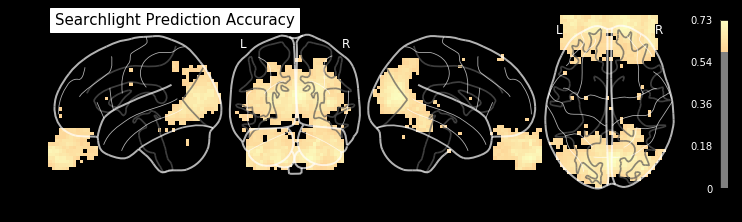

In [39]:
from nilearn.plotting import plot_glass_brain
plot_glass_brain(searchlight_img, black_bg=True, colorbar=True, display_mode='lyrz',
                 threshold=0.6, cmap='magma', title='Searchlight Prediction Accuracy')

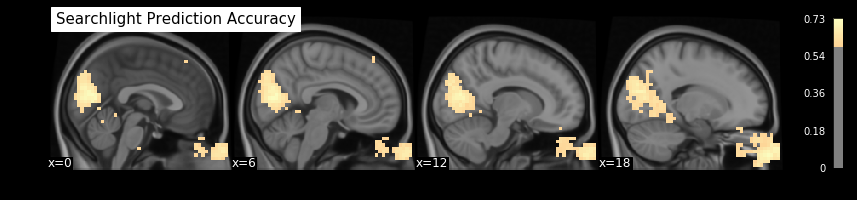

In [40]:
from nilearn.plotting import plot_stat_map
plot_stat_map(searchlight_img, cmap='magma', bg_img=anat, colorbar=True,
              display_mode='x', threshold=0.6, cut_coords=[0, 6, 12, 18],
              title='Searchlight Prediction Accuracy');

As expected and already seen before, the hotspots with high prediction accuracy are around the primary visual cortex (in the back of the head) and around the eyes.

# PyMVPA

[PyMVPA](http://www.pymvpa.org/) is a Python package intended to ease statistical learning analyses of large datasets. It offers an extensible framework with a high-level interface to a broad range of algorithms for classification, regression, feature selection, data import, and export.

The power in PyMVPA lies in its flexibility with classifiers. PyMVPA is able to use many classifiers from LIBSVM and scikit-learn, and the overall list that are at your hands is impressive. The following are only some of the classifiers that you can choose from:

- Bayesian Linear Regression (BLR)
- Elastic-Net (ENET) regression classifier
- Gaussian Discriminant Analyses (LDA and QDA)
- Gaussian Naive Bayes Classifier (GNB)
- Gaussian Process Regression (GPR)
- GLM-Net (GLMNET) regression and classifier
- k-Nearest-Neighbour classifier (kNN)
- Least angle regression (LARS)
- Penalized logistic regression classifier
- Similarity functions for prototype-based projection
- Sparse Multinomial Logistic Regression classifier (SMLR)
- SVM and SVR machines

**Note:** The content of this notebook is taken and adapted from the [PyMVPA](http://www.pymvpa.org/) homepage and serves an illustrative purpose. For more information and better understanding, go directly to [PyMVPA](http://www.pymvpa.org/).

Having said so, let's take a look at PyMVPA's **Searchlight** example.

## Preparation

As searchlight analyses are usually quite expensive in terms of computational resources, we are going to enable some progress output to entertain us while we are waiting.

In [41]:
from mvpa2.suite import *

# enable debug output for searchlight call
if __debug__:
    debug.active += ["SLC"]

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/mvpa2/datasets/sources/skl_data.py:32: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  argnames, varargs, varkw, defaults = inspect.getargspec(fx)
<string>:60: DeprecationWarning: invalid escape sequence \#
<string>:59: DeprecationWarning: invalid escape sequence \#
<string>:59: DeprecationWarning: invalid escape sequence \#
<string>:65: DeprecationWarning: invalid escape sequence \c
/opt/miniconda-latest/envs/neuro/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds

PyMVPA uses dataset objects that contain all necessary information for the searchlight analysis in one object. So let's construct such a dataset object. The only thing we need is: our data, the labels, the chanks and a mask that specifies the region in which we want to run the searchlight.

In [42]:
ds = fmri_dataset(samples=func,
                  targets=labels,
                  chunks=chunks,
                  mask=get_mask('both'))

 * Please note: warnings are printed only once, but underlying problem might occur many times *


Now, as we saw before. Running the searchlight on each and every voxel might be very computation intensive. Luckily PyMVPA's searchlight allows some shortcuts. For example, we can run the searchlight only on every X voxel. If we do so, we will have many holes/missing values for all the voxels that we didn't do the cross-validation for.

One solution to counteract this is by filling out those empty voxels with the average accuracy of all surrounding searchlight spheres. In other words, the value stored in each voxel is the average prediction accuracy of all the spheres that include this voxel in their computation.

It will make more sense later on. But first, let's specify the function that does this step:

In [43]:
def fill_in_scattered_results(sl, dataset, roi_ids, results):
    """Function to aggregate results - This requires the searchlight
    conditional attribute 'roi_feature_ids' to be enabled"""
    import numpy as np
    from mvpa2.datasets import Dataset
    resmap = None
    for resblock in results:
        for res in resblock:
            if resmap is None:
                # prepare the result container
                resmap = np.zeros((len(res), dataset.nfeatures),
                                  dtype=res.samples.dtype)
                observ_counter = np.zeros(dataset.nfeatures, dtype=int)
            # project the result onto all features -- love broadcasting!
            resmap[:, res.a.roi_feature_ids] += res.samples
            # increment observation counter for all relevant features
            observ_counter[res.a.roi_feature_ids] += 1
    # when all results have been added up average them according to the number
    # of observations
    observ_mask = observ_counter > 0
    resmap[:, observ_mask] /= observ_counter[observ_mask]
    result_ds = Dataset(resmap,
                        fa={'observations': observ_counter})
    if 'mapper' in dataset.a:
        import copy
        result_ds.a['mapper'] = copy.copy(dataset.a.mapper)
    return result_ds

## Setting up the Searchlight Object

Now we're good to go! So, as before, we need to specify a cross-validation scheme. Let's use again a Leave-one-out cross-validation, i.e. a N-Fold approach.

In [44]:
# Specify cross-validation scheme
cv_scheme = NFoldPartitioner(cvtype=1)

As a next step, we need to specify the classifier we want to use. Here is where PyMVPA shines. There are so many... But for this example, let's focus again on the linear support vector machine classifier:

In [45]:
clf = LinearCSVMC()

Let's put this all into a cross-validation object.

In [46]:
cv = CrossValidation(clf,
                     cv_scheme,
                     errorfx=mean_match_accuracy,
                     enable_ca=['stats'])

And as a final step, we need again to specify the size of the sphere and also the step-size we want to use, i.e. the distance between spheres.

In [47]:
# Radius of the searchlight sphere
sphere_radius = 2   # in voxels

In [48]:
# Step size / voxel distance between spheres
nth_element = 50

This `nth_element` parameter is great as it reduces the computation time of the searchlight. And as mentioned above, using the `fill_in_scattered_results()` function allows us to fill up all the missing values that we didn't compute. Additionally, this serves as some kind of data smoothing, which also increases the signal-to-noise ratio (SNR).

Now we're ready and can put this all into the searchlight classifier object:

In [49]:
sl = sphere_searchlight(cv,
                        radius=sphere_radius,
                        center_ids=range(0,
                                         ds.shape[1],
                                         nth_element),
                        space='voxel_indices',
                        results_fx=fill_in_scattered_results,
                        postproc=mean_sample(),
                        enable_ca=['calling_time', 'roi_feature_ids'])
sl.nproc = 1  # Specifies the number of parallel jobs

And we're good to go. Let's train the classifier!

In [50]:
sl_map = sl(ds)

[SLC] DBG:                              Starting computing block for 748 elements
[SLC] DBG:                              +0:00:00 _______[0%]_______ -0:02:10  ROI 1 (1/748), 17 features

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/mvpa2/misc/attrmap.py:153: FutureWarning: Conversion of the second argument of issubdtype from `str` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype(str).type`.
  if not np.issubdtype(attr.dtype, str) and not self.mapnumeric:
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/mvpa2/clfs/libsvmc/svm.py:215: FutureWarning: Conversion of the second argument of issubdtype from `'c'` to `bytes` is deprecated. In future, it will be treated as `np.bytes_ == np.dtype('c').type`.
  if ( np.issubdtype(self.ca.trained_targets.dtype, 'c') or
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/mvpa2/clfs/libsvmc/svm.py:216: FutureWarning: Conversion of the second argument of issubdtype from `'U'` to `str` is deprecated. In future, it will be treated as `np.str_ == np.dtype('U').type`.
  np.issubdtype(self.ca.trained_targets.dtype, 'U') ):


[SLC] DBG:                              +0:01:15 ======[100%]====== 0:00:00  ROI 37351 (748/748), 22 features 


So, what does the result look like? Let's put it back into an MRI image and plot it on the glass brain.

In [51]:
# Access the searchlight output data and put it into an MRI image
sl_data = ds.mapper.reverse(sl_map.S)[0, ...]

from nilearn.image import new_img_like
sl_img = new_img_like(func, sl_data)

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


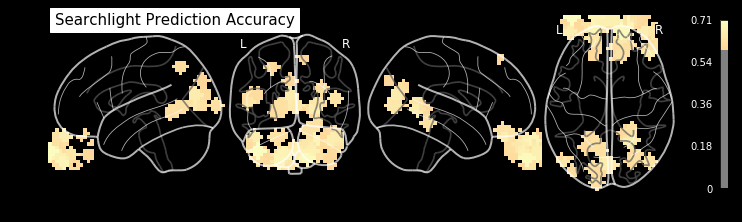

In [52]:
# Plotting the searchlight results on the glass brain
from nilearn.plotting import plot_glass_brain
plot_glass_brain(sl_img, black_bg=True, colorbar=True, display_mode='lyrz',
                 threshold=0.60, cmap='magma', title='Searchlight Prediction Accuracy')

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


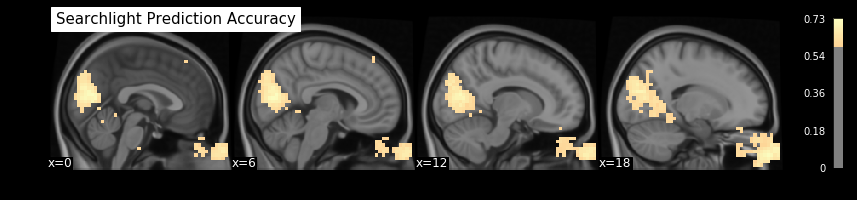

In [53]:
from nilearn.plotting import plot_stat_map
plot_stat_map(searchlight_img, cmap='magma', bg_img=anat, colorbar=True,
              display_mode='x', threshold=0.6, cut_coords=[0, 6, 12, 18],
              title='Searchlight Prediction Accuracy');

**Note about parallel execution:** The PyMVPA version in this docker container doesn't run in parallel, i.e. it runs only on one core. If you want to have parallel execution, you need to create a Python 2.7 environment and install `PyMVPA` and `pprocess`. Once this is done, you can use the parameter `sl.nproc` to define how many parallel jobs you want to use.